## A First Attempt at PAC in Spark

In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
import paclib

Spark setup. We initialize a session using only the local machine.

In [2]:
spark = (SparkSession.builder.appName("pacdb")
         #.master("spark://boss:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         #.config("spark.sql.warehouse.dir", "hdfs://nn:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/28 22:06:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Matplotlib setup.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

Import data from `data/lung.parquet`. This is a kaggle dataset of lung cancer patients, to which I have added randomly-generated names (see `data/augment_lung.py`).

In [4]:
lung_df = spark.read.parquet("./data/lung.parquet")
lung_rdd = lung_df.rdd

lung_df.show()

24/02/28 22:06:25 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------------+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|             name|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|Occupational Hazards|Genetic Risk|Chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring|Cancer|
+-----------------+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------

How many patients are self-reported smokers? They are asked to rate their smoking on a scale from 1-7, we'll count those who report 3 or higher.

This is an example of querying Spark through the Dataframe API.

In [5]:
smokers = lung_df.filter(lung_df["Smoking"] >= 3) # Smoking is on 1-7 scale
smokers.count()

597

Spark also supports SQL queries. We can register the dataframe as a table and then query it using SQL.

In [6]:
lung_df.write.saveAsTable("lung", mode="overwrite")
spark.sql("SELECT COUNT(*) FROM lung WHERE smoking >= 3").show()

24/02/28 22:06:30 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/02/28 22:06:30 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
24/02/28 22:06:34 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
24/02/28 22:06:34 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore michael@10.0.0.4
24/02/28 22:06:34 WARN ObjectStore: Failed to get database default, returning NoSuchObjectException
24/02/28 22:06:36 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
24/02/28 22:06:36 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
24/02/28 22:06:36 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
24/02/28 22:06:36 WARN Hi

+--------+
|count(1)|
+--------+
|     597|
+--------+



In [7]:
paclib.sample_proportionately(lung_df, ["Gender","Smoking"], 0.1).show()

{'2_7': 0.004, '1_5': 0.001, '1_4': 0.004900000000000001, '2_8': 0.0028000000000000004, '1_3': 0.0079, '2_4': 0.001, '1_6': 0.0028000000000000004, '1_8': 0.0061, '1_7': 0.016700000000000003, '1_1': 0.0102, '2_3': 0.009300000000000001, '1_2': 0.0102, '2_2': 0.012, '2_1': 0.0079, '2_6': 0.0032}
+------------------+-----+----------+---+------+-------------+-----------+------------+--------------------+------------+--------------------+-------------+-------+-------+--------------+----------+-----------------+-------+-----------+-------------------+--------+---------------------+------------------------+-------------+---------+-------+------+
|              name|index|Patient Id|Age|Gender|Air Pollution|Alcohol use|Dust Allergy|Occupational Hazards|Genetic Risk|Chronic Lung Disease|Balanced Diet|Obesity|Smoking|Passive Smoker|Chest Pain|Coughing of Blood|Fatigue|Weight Loss|Shortness of Breath|Wheezing|Swallowing Difficulty|Clubbing of Finger Nails|Frequent Cold|Dry Cough|Snoring|Cancer|
+-

### Sampling

Spark provides two functions for sampling out of a dataset. `sample` selects a chosen percentage of the dataset. `sampleBy` allows to further specify the distribution of the sample.

See `sample_proportionately` in `paclib/main.py` for my attempt at reproducing the sampling strategy from the PAC-ML code.

Here I use `sample` directly as we are only querying one one-dimensional variable.

In [8]:
df = lung_df
trials = 1000
sampling_rate = 0.5

n = df.count()

samples = []
for i in range(trials):
    s = (df.sample(fraction=0.5, withReplacement=True)  # 50% sampling rate
         .filter(lung_df["Smoking"] >= 3)  # run query on sample
         .count())
    samples.append(s)  # store result of query

samples = [s * (1/sampling_rate) for s in samples]  # so that counts are not halved

These are the samples that we have:

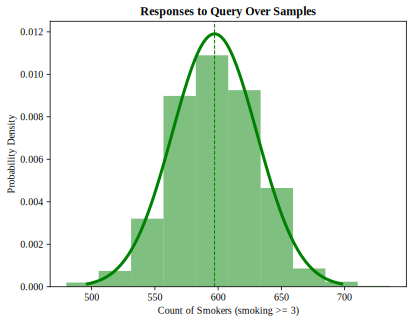

In [9]:
plt.hist(samples, bins=10, density=True, alpha=0.5, color='g')

mu = np.mean(samples)
sigma = np.std(samples)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), color='g', linewidth=3)

# highlight mean
plt.axvline(mu, color='g', linestyle='dashed', linewidth=1)
# label
#plt.text(mu+17, 0.0117, f'$\mu={mu:.2f}$', ha='center', va='top', fontsize=8)

# label the axes
plt.title('Responses to Query Over Samples')
plt.xlabel('Count of Smokers (smoking >= 3)')
plt.ylabel('Probability Density')
plt.savefig("figs/samples.png")

In [10]:
{'mean': mu, 'variance': sigma**2, 'covariance': np.cov(samples, samples)}

{'mean': 597.184,
 'variance': 1121.966144,
 'covariance': array([[1123.08923323, 1123.08923323],
        [1123.08923323, 1123.08923323]])}

(We use variance as the 1D equivalent of covariance.)

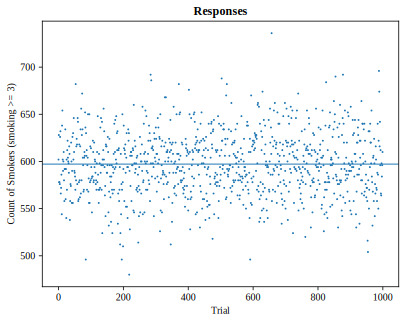

In [11]:
# plot covariance
plt.scatter(range(0,1000), samples, alpha=1, color='tab:blue', s=1)

# depict mean as a line
plt.axhline(y=np.mean(samples), color='tab:blue', linestyle='-', lw=1)

plt.title('Responses')
plt.xlabel('Trial')
plt.ylabel('Count of Smokers (smoking >= 3)')
# min y axis must be 0
#plt.ylim(bottom=0)
plt.savefig("figs/variance.png")

### Noise

Now we calculate the noise to add. I've attempted to construct what I need based on the PAC-ML code, but this probably has many errors.

I am using the following for the variance of the noise, taken from the end of PAC-ML's `rand_mechanism_noise` (but it is mostly a guess as I am unsure about what some of that code does):
$$ ((\text{avg\_dist} + c) / (2*(\text{max\_mi} / 2.))) $$

In [16]:
c = 0.001
max_mi = 1/32

# I am somewhat confused by the paired sampling in the PAC-ML code. I conclude that
# avg_dist is the distance between every pair of samples. To reconstruct that I'll subtract
# samples 1, 3, 5... from 0, 2, 4...
dists = [abs(samples[i] - samples[i+1]) for i in range(0, len(samples), 2)]
avg_dist = np.mean(dists)

# At different levels of MI, compute noise to add?
for max_mi in [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]:
    print(f"avg_dist: {avg_dist}, c: {c}, max_mi: {max_mi:8} => {paclib.noise_to_add_parameters(avg_dist, c, max_mi)}")

noised_samples = [s + paclib.noise_to_add(avg_dist, c, max_mi) for s in samples]

avg_dist: 38.264, c: 0.001, max_mi: 0.015625 => GaussianDistribution(mean=0, variance=2448.96)
avg_dist: 38.264, c: 0.001, max_mi:  0.03125 => GaussianDistribution(mean=0, variance=1224.48)
avg_dist: 38.264, c: 0.001, max_mi:   0.0625 => GaussianDistribution(mean=0, variance=612.24)
avg_dist: 38.264, c: 0.001, max_mi:    0.125 => GaussianDistribution(mean=0, variance=306.12)
avg_dist: 38.264, c: 0.001, max_mi:     0.25 => GaussianDistribution(mean=0, variance=153.06)
avg_dist: 38.264, c: 0.001, max_mi:      0.5 => GaussianDistribution(mean=0, variance=76.53)
avg_dist: 38.264, c: 0.001, max_mi:      1.0 => GaussianDistribution(mean=0, variance=38.265)
avg_dist: 38.264, c: 0.001, max_mi:      2.0 => GaussianDistribution(mean=0, variance=19.1325)
avg_dist: 38.264, c: 0.001, max_mi:      4.0 => GaussianDistribution(mean=0, variance=9.56625)


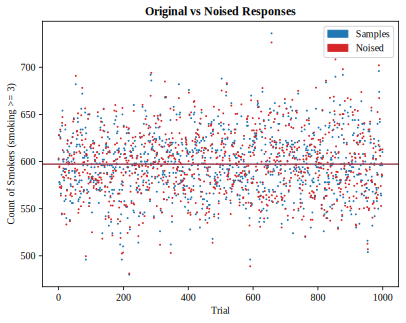

In [17]:
# plot samples
plt.scatter(range(0,1000), samples, alpha=1, color='tab:blue', s=1)
plt.axhline(y=np.mean(samples), color='tab:blue', linestyle='-', lw=1)

# plot noised
plt.scatter(range(0,1000), noised_samples, alpha=1, color='tab:red', s=1)
plt.axhline(y=np.mean(noised_samples), color='tab:red', linestyle='-', lw=1)

plt.title('Original vs Noised Responses')
plt.xlabel('Trial')
plt.ylabel('Count of Smokers (smoking >= 3)')
plt.legend(handles=[mpatches.Patch(color='tab:blue', label='Samples'), mpatches.Patch(color='tab:red', label='Noised')], loc='upper right')
#plt.ylim(bottom=0)
plt.savefig("figs/original-vs-noised.png")